# Example for execution of multiple circuits in QPUs

In this notebook, some examples of simple execution without communications will be shown. The scheme followed is going to be the similar in every case, even for the most complex ones. First, the `cunqa` module imports will be done.

<div class="alert alert-block alert-warning">
<b>Warning:</b> The path to the cunqa module has to be added if cunqa is not in the PYTHONPATH list of directories. This is specially important for the ones that built CUNQA from source and are not using it as a LMOD module (in which case, if the installation was done correctly, cunqa module will be inside PYTHONPATH). As a default example, the path added is the $HOME path, but it should be adapted.
</div> 

In [8]:
import os, sys

# If this is not done before the cunqa module imports, it will fail to find them
sys.path.append(os.getenv("HOME"))

from cunqa import get_QPUs, qraise, gather, qdrop
from cunqa.qpu import run

## Small circuit example
### Turning ON the vQPUs

After the imports, we begin with the body of the program. First of all, the virtual QPUs (vQPUs) must be deployed. To achieve this there are two options:

1. **Using the `qraise` command**.
2. **Using the `qraise()` Python function**.
   
Both achieve the same: turning on the vQPUs. In fact, the `qraise()` Python function employs the `qraise` bash command to achieve this. The difference lies in the fact that the `qraise()` Python function integrates the resource management into the Python API worflow, while the `qraise` bash command needs to be executed before the workflow starts in order to have the QPUs raised beforehand.

In order to make this example self-contained the `qraise` Python function will be employed.

In [9]:
family = qraise(2, "00:10:00", simulator = "Aer",  co_located = True)
# bash equivalent: qraise -n 2 -t 00:10:00 --sim Aer --co-located

qpus = get_QPUs(co_located=True, family=family)

print("\nQPUs properties:")
for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend['name']}, simulator: {q.backend['simulator']}, version: {q.backend['version']}.")

Requested QPUs with command:
	qraise -n 2 -t 00:10:00 --simulator=Aer --co-located
QPUs ready to work ✅

QPUs properties:
QPU 377618_294450, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.
QPU 377618_294451, backend: SimpleBackend, simulator: AerSimulator, version: 0.0.1.


Two vQPUs were raised for ten minutes, without communications and employing the Aer simulator to execute the circuits. Moreover, the flag `co_located` was set to true, meaning that these vQPUs will run in a co-located scheme, i.e, they will be accesible from every node of the cluster. 

<div class="alert alert-block alert-warning">
<b>Warrning:</b> If the <i>co_located</i> flag was not set to true, then the vQPUs will be available only if the user is inside the node they are deployed on (similar to how it works with actual GPUs).
</div> 

On the oher hand, the method `get_QPUs()` accesses the information of the raised vQPUs and instantiates one `QPU` object for each. This `QPU` instance possesses the information of its related vQPU and, also, a connection to it. This way, this object is the one responsible of sending the circuit to get it executed. 

### Designing the circuit 

There are three options for designing the circuit:

- **`CunqaCircuit`**.
- **`QuantumCircuit`** (from Qiskit).
- **`json`**.

`CunqaCircuit` is designed to be similar to the `QuantumCircuit` but allowing communication instructions. This is done to reduce the learning curve, recognizing the fact that `QuantumCircuit` is a well stablished API inside quantum computation programmers.

The `json` format is used as an intermediate representation (IR). It is a much less human-understandable format employed to send the information to the vQPUs, but it can be directly used (as the complex example will show).

But because in this example communication directives are not employed, the `QuantumCircuit` class from Qiskit is employed.

In [10]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

n = 5 # number of qubits

qc = QuantumCircuit(n)

qc.x(0); qc.x(n-1); qc.x(n-2)
qc.append(QFT(n), range(n))
qc.append(QFT(n).inverse(), range(n))
qc.measure_all()

display(qc.draw())

┌───┐┌──────┐┌───────┐ ░ ┌─┐            
   q_0: ┤ X ├┤0     ├┤0      ├─░─┤M├────────────
        └───┘│      ││       │ ░ └╥┘┌─┐         
   q_1: ─────┤1     ├┤1      ├─░──╫─┤M├─────────
             │      ││       │ ░  ║ └╥┘┌─┐      
   q_2: ─────┤2 QFT ├┤2 IQFT ├─░──╫──╫─┤M├──────
        ┌───┐│      ││       │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤ X ├┤3     ├┤3      ├─░──╫──╫──╫─┤M├───
        ├───┤│      ││       │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤ X ├┤4     ├┤4      ├─░──╫──╫──╫──╫─┤M├
        └───┘└──────┘└───────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════╩══╩══╩══╩══╩═
                                  0  1  2  3  4

### Executing the circuit in the vQPUs
It is time to execute and display the results by following these steps:

1. Calling the `run` function with: the circuit, the QPU and the run parameters. This method will return a `qjob.QJob` object.
<div class="alert alert-block alert-info">
<b>Note:</b> The `run()` function is <b>asynchronous</b>.
</div>

2. To get the results of the simulation, the property `QJob.result` is called, returning a `Result` object that stores the execution information. Depending on the simulator, there will be more or less information.
3. <div class="alert alert-block alert-info">
<b>Note:</b> This is a <b>synchronous</b> method, blocking the execution until the vQPU retrieves the results obtained.
</div>

4. From the `Result` object obtained, the counts dictionary can be obtained by accessing the `Result.counts` property. Another property independent from the simulator is `Result.time_taken`, that stores the time spent in the simulation in seconds.

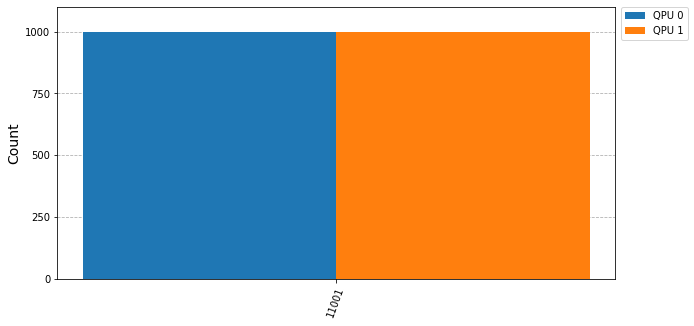

In [11]:
counts = []
for i, qpu in enumerate(qpus):
    
    # 1)
    qjob = run(qc.decompose().decompose(), qpu, shots = 1000) # non-blocking call

    # 2)
    result = qjob.result # bloking call

    # 3)
    time = result.time_taken
    counts.append(result.counts)

%matplotlib inline
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

plot_histogram(counts, figsize = (10, 5), bar_labels=False, legend = [f"QPU {i}" for i in range(len(qpus))])

## Complex circuit example

The following circuit is more complex than the previous one: it has 15 qubits and 10 intermediate measurements. The execution of this circuit is far more expensive than the previous one, as all its shots are executed in only one QPU, i.e., sequentially. 

In [12]:
import json

# impoting from examples/circuits/
with open("circuits/circuit_15qubits_10layers.json", "r") as file:
    circuit = json.load(file)

qjob = run(circuit, qpus[0], shots = 1000)

result = qjob.result # bloking call
time = result.time_taken
counts.append(result.counts)

print(f"Result: Time taken: {time} s.")


Result: Time taken: 20.09280778 s.


This cost that this circuit has allows us to really display how CUNQA parallelizes the execution of the circuits when sending to the different vQPUs available. So, just as in the previous example, the circuit is executed in every vQPU available.

In [13]:
import time

qjobs = []
n = len(qpus)

tick = time.time()

for qpu in qpus:
    qjobs.append(run(circuit, qpu, shots = 1000))
    
results = gather(qjobs) # this is a bloking call
tack = time.time()

print(f"Time taken to run {n} circuits in parallel: {tack - tick} s.")
print("\nTime of each execution:")
for i, result in enumerate(results):
    print(f"For QJob {i}, time taken: {result.time_taken} s.")
print()

qdrop(family)



Time taken to run 2 circuits in parallel: 20.766820907592773 s.

Time of each execution:
For QJob 0, time taken: 20.749891593 s.
For QJob 1, time taken: 20.213398957 s.

Removed job(s) with ID(s): 377618 


The results show how the time taken is (approximately) the same as the previous execution even though the number of the shots executed has been multiplied by the number of the vQPUs available (in this case, duplicated).

So it can be confirmed that **the circuits were run in parallel**.

Moreover, the `qdrop()` Python function is called at the end of the program to drop the vQPUs, as they will not be used further. This relinquishes the classical resources employed in the execution of the vQPUs. Just as with the `qraise()`, `qdrop()` possesses a bash command counterpart that performs the same functionality.